In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rc('axes', unicode_minus=False)

In [2]:
os.getcwd()

'C:\\Users\\user\\금융시계열'

# 전처리 과정

### 첫 번째 데이터 : 국제 유가 데이터 전처리

In [3]:
#아래 데이터들을 한국석유공사(https://www.petronet.co.kr/v3/index.jsp)에서 찾았는데 각 데이터가 1년단위로 나눠져 있기에 각각의 파일로
#받아서 변수에 대입해준다.
oil1 = pd.read_csv('일일국제원유가격(20190226).csv', encoding = 'cp949')
oil2 = pd.read_csv('일일국제원유가격(20200226).csv', encoding = 'cp949')
oil3 = pd.read_csv('일일국제원유가격(20210226).csv', encoding = 'cp949')
oil4 = pd.read_csv('일일국제원유가격(20210626).csv', encoding = 'cp949')

In [4]:
#깔끔하게 보여주기 위한 과정
oil = pd.concat([oil1[:-5],oil2[:-5],oil3[:-5],oil4[:-5]])
oil_month_day = oil['Unnamed: 7'].str.split('?', expand = True)
oil = pd.concat([oil, oil_month_day], axis = 1)
oil['일'] = oil['Unnamed: 6'] + oil[0] + oil[1]
oil = oil[['일', 'Dubai','Brent','WTI','Oman']]
oil

,일,Dubai,Brent,WTI,Oman
0,2018년02월27일,64.02,66.63,63.01,64.47
1,2018년02월28일,63.22,65.78,61.64,63.39
2,2018년03월01일,61.42,63.83,60.99,61.71
3,2018년03월02일,60.28,64.37,61.25,60.68
4,2018년03월05일,61.32,65.54,62.57,61.88
...,...,...,...,...,...
74,2021년06월14일,72.01,72.86,70.88,72.06
75,2021년06월15일,71.79,73.99,72.12,71.87
76,2021년06월16일,72.78,74.39,72.15,72.82
77,2021년06월17일,72.35,73.08,71.04,72.37


In [5]:
#'일'데이터를 datetime형으로 바꿔준다.
oil['일'] = pd.to_datetime(oil.일, format = '%Y년%m월%d일')
oil.head()

,일,Dubai,Brent,WTI,Oman
0,2018-02-27,64.02,66.63,63.01,64.47
1,2018-02-28,63.22,65.78,61.64,63.39
2,2018-03-01,61.42,63.83,60.99,61.71
3,2018-03-02,60.28,64.37,61.25,60.68
4,2018-03-05,61.32,65.54,62.57,61.88


In [6]:
oil.info()
#데이터들의 형태를 보면 지금 object형태로 되어있는게 많다. 계산을 쉽게 하기 위해선 숫자형으로 바꿔줘야한다.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 854 entries, 0 to 78
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일       854 non-null    datetime64[ns]
 1   Dubai   854 non-null    object        
 2   Brent   854 non-null    float64       
 3   WTI     854 non-null    object        
 4   Oman    854 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 40.0+ KB


In [7]:
#데이터 타입 변경
oil[['Dubai','WTI','Oman']] = oil[['Dubai','WTI','Oman']].apply(pd.to_numeric, errors = 'coerce')
oil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 854 entries, 0 to 78
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일       854 non-null    datetime64[ns]
 1   Dubai   828 non-null    float64       
 2   Brent   854 non-null    float64       
 3   WTI     835 non-null    float64       
 4   Oman    828 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 40.0 KB


In [8]:
#바로 앞의 데이터로 결측치 값들을 채워준다.
oil.fillna(method = 'ffill', inplace = True)
oil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 854 entries, 0 to 78
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일       854 non-null    datetime64[ns]
 1   Dubai   854 non-null    float64       
 2   Brent   854 non-null    float64       
 3   WTI     854 non-null    float64       
 4   Oman    854 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 40.0 KB


In [9]:
#현재 갖고 있는 데이터는 두바이유, brent유, 텍사스유, 오만유인데 이의 차이는 크게는 없다고 생각해서 후의 분석에서 이의 평균을 
#이용하기 위해서 평균값을 계산.
oil['oil_mean'] = (oil['Dubai'] + oil['Brent'] + oil['WTI'] + oil['Oman']) / 4
oil.head()

,일,Dubai,Brent,WTI,Oman,oil_mean
0,2018-02-27,64.02,66.63,63.01,64.47,64.5325
1,2018-02-28,63.22,65.78,61.64,63.39,63.5075
2,2018-03-01,61.42,63.83,60.99,61.71,61.9875
3,2018-03-02,60.28,64.37,61.25,60.68,61.6450
4,2018-03-05,61.32,65.54,62.57,61.88,62.8275


In [10]:
#후 계산에서 다른 데이터에선 날짜 데이터가 모두 'Date'로 서술되었기에 이를 편하게 하기위해 'Date'로 따라 변경해준다.
oil = oil.rename(columns = {'일':'Date'})
oil

,Date,Dubai,Brent,WTI,Oman,oil_mean
0,2018-02-27,64.02,66.63,63.01,64.47,64.5325
1,2018-02-28,63.22,65.78,61.64,63.39,63.5075
2,2018-03-01,61.42,63.83,60.99,61.71,61.9875
3,2018-03-02,60.28,64.37,61.25,60.68,61.6450
4,2018-03-05,61.32,65.54,62.57,61.88,62.8275
...,...,...,...,...,...,...
74,2021-06-14,72.01,72.86,70.88,72.06,71.9525
75,2021-06-15,71.79,73.99,72.12,71.87,72.4425
76,2021-06-16,72.78,74.39,72.15,72.82,73.0350
77,2021-06-17,72.35,73.08,71.04,72.37,72.2100


In [11]:
#이젠 값을 날짜와 평균값만 이용할 것이기에 관련 값만 남기고 나머진 다 탈락시켜준다.
oil1 = oil[['Date','oil_mean']]
oil1
#유가 데이터 전처리 완료

,Date,oil_mean
0,2018-02-27,64.5325
1,2018-02-28,63.5075
2,2018-03-01,61.9875
3,2018-03-02,61.6450
4,2018-03-05,62.8275
...,...,...
74,2021-06-14,71.9525
75,2021-06-15,72.4425
76,2021-06-16,73.0350
77,2021-06-17,72.2100


### 두 번째 데이터 : KOSPI 지수 전처리

In [12]:
#아래 코스피 데이터는 yahoo finance(https://finance.yahoo.com/)에서 다운 받은 데이터이다.
kospi = pd.read_csv('^KS11.csv')
kospi.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-27,2474.080078,2480.790039,2456.139893,2456.139893,2456.139893,271200.0
1,2018-02-28,2447.110107,2460.120117,2426.209961,2427.360107,2427.360107,367600.0
2,2018-03-02,2406.570068,2410.340088,2387.250000,2402.159912,2402.159912,320400.0
3,2018-03-05,2405.919922,2407.979980,2374.800049,2375.060059,2375.060059,312300.0
4,2018-03-06,2400.669922,2413.010010,2392.870117,2411.409912,2411.409912,400100.0


In [13]:
#날짜와 종가데이터만 가져가고 나머진 탈락시켜준다,
kospi = kospi[['Date','Close']]
#'Date'열의 값들의 type을 변경해준다,
kospi['Date'] = pd.to_datetime(kospi.Date, format = '%Y-%m-%d')
kospi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    815 non-null    datetime64[ns]
 1   Close   813 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.9 KB


In [14]:
#후의 결합을 쉽게하기 위해 'Close'를 'KOSPI'로 바꿔주며 마무리
kospi.rename(columns = {'Close' : 'KOSPI'}, inplace = True)
kospi.head()

,Date,KOSPI
0,2018-02-27,2456.139893
1,2018-02-28,2427.360107
2,2018-03-02,2402.159912
3,2018-03-05,2375.060059
4,2018-03-06,2411.409912


### 세 번째 데이터 : KOSDAQ 지수 전처리

In [15]:
#앞선 kospi데이터 전처리와 과정 정확히 동일하다.
#해당 데이터도 yahoo finance에서 얻어왔다.
kosdaq = pd.read_csv('^KQ11.csv')
kosdaq = kosdaq[['Date','Close']]
kosdaq['Date'] = pd.to_datetime(kosdaq.Date, format = '%Y-%m-%d')
kosdaq.rename(columns = {'Close' : 'KOSDAQ'}, inplace = True)
kosdaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    816 non-null    datetime64[ns]
 1   KOSDAQ  814 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.9 KB


### 네 번째 데이터 : NASDAQ 지수 전처리

In [16]:
#나스닥도 동일
nasdaq = pd.read_csv('^IXIC.csv')
nasdaq = nasdaq[['Date','Close']]
nasdaq['Date'] = pd.to_datetime(nasdaq.Date, format = '%Y-%m-%d')
nasdaq.rename(columns = {'Close' : 'NASDAQ'}, inplace = True)
nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    835 non-null    datetime64[ns]
 1   NASDAQ  835 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.2 KB


### 다섯 번째 데이터 : ESG ETF 지수 전처리

In [17]:
#다음은 종속변수 값으로 이용한 ESG ETF값들이다.
#국내 주식시장에 총 9개의 ESG ETF가 공개되어있다. 이중 시총 규모, 상장일 등 기준에 근거해 5개의 ETF ESG를 추출해서 해당 5종목의 평균을
#ESG ETF 지수로 이용하도록 하겠다.

In [18]:
#첫 번째 Tiger MSCI Korea ESG리더스(289260)의 정보
#아래 모든 데이터는 위의 데이터들과 같이 yahoo finance에서 가져왔다.
tiger_korea_esg_readers = pd.read_csv('289260.KS.csv')
tiger_korea_esg_readers = tiger_korea_esg_readers[['Date','Close']]
tiger_korea_esg_readers['Date'] = pd.to_datetime(tiger_korea_esg_readers.Date, format = '%Y-%m-%d')
tiger_korea_esg_readers.rename(columns = {'Close' : 'tiger_korea_esg_readers'}, inplace = True)
tiger_korea_esg_readers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     815 non-null    datetime64[ns]
 1   tiger_korea_esg_readers  813 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.9 KB


In [19]:
#두 번째 Tiger MSCI Korea ESG universal(289250)의 정보
tiger_korea_esg_universal = pd.read_csv('289250.KS.csv')
tiger_korea_esg_universal = tiger_korea_esg_universal[['Date','Close']]
tiger_korea_esg_universal['Date'] = pd.to_datetime(tiger_korea_esg_universal.Date, format = '%Y-%m-%d')
tiger_korea_esg_universal.rename(columns = {'Close' : 'tiger_korea_esg_universal'}, inplace = True)
tiger_korea_esg_universal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       815 non-null    datetime64[ns]
 1   tiger_korea_esg_universal  813 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.9 KB


In [20]:
#세 번째 KODEX MSCI KOREA ESG(289040)의 정보
kodex_esg_universal = pd.read_csv('289040.KS.csv')
kodex_esg_universal = kodex_esg_universal[['Date','Close']]
kodex_esg_universal['Date'] = pd.to_datetime(kodex_esg_universal.Date, format = '%Y-%m-%d')
kodex_esg_universal.rename(columns = {'Close' : 'kodex_esg_universal'}, inplace = True)
kodex_esg_universal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 815 non-null    datetime64[ns]
 1   kodex_esg_universal  813 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.9 KB


In [21]:
#네 번째 ARIRANG ESG우수기업(278420)의 정보
arirang_esg = pd.read_csv('278420.KS (2).csv')
arirang_esg = arirang_esg[['Date','Close']]
arirang_esg['Date'] = pd.to_datetime(arirang_esg.Date, format = '%Y-%m-%d')
arirang_esg.rename(columns = {'Close' : 'arirang_esg'}, inplace = True)
arirang_esg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         815 non-null    datetime64[ns]
 1   arirang_esg  813 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.9 KB


In [22]:
#다섯 번째 KBSTAR ESG사회책임투자(290130)의 정보
kb_esg = pd.read_csv('290130.KS.csv')
kb_esg = kb_esg[['Date','Close']]
kb_esg['Date'] = pd.to_datetime(kb_esg.Date, format = '%Y-%m-%d')
kb_esg.rename(columns = {'Close' : 'KB_esg'}, inplace = True)
kb_esg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    816 non-null    datetime64[ns]
 1   KB_esg  814 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.9 KB


In [23]:
#위 정보들의 index값들을 esg란 변수에 새롭게 넣어준다.
esg = pd.concat([kb_esg,tiger_korea_esg_readers['tiger_korea_esg_readers'],tiger_korea_esg_universal['tiger_korea_esg_universal'],
                kodex_esg_universal['kodex_esg_universal'],arirang_esg['arirang_esg']], axis =1)
esg.head()

,Date,KB_esg,tiger_korea_esg_readers,tiger_korea_esg_universal,kodex_esg_universal,arirang_esg
0,2018-02-26,10146.2002,9195.0,9380.0,9590.0,10075.0
1,2018-02-27,10175.0000,9195.0,9345.0,9590.0,10060.0
2,2018-02-28,10060.0000,9195.0,9345.0,9590.0,9910.0
3,2018-03-02,9975.0000,9195.0,9125.0,9590.0,9770.0
4,2018-03-05,9855.0000,9195.0,9125.0,9375.0,9830.0


In [24]:
#각 값들의 평균을 계산.
esg['esg_mean_index'] = (esg['KB_esg'] + esg['tiger_korea_esg_readers'] + esg['tiger_korea_esg_universal'] + esg['kodex_esg_universal'] + esg['arirang_esg'])/5
esg.head()

,Date,KB_esg,tiger_korea_esg_readers,tiger_korea_esg_universal,kodex_esg_universal,arirang_esg,esg_mean_index
0,2018-02-26,10146.2002,9195.0,9380.0,9590.0,10075.0,9677.24004
1,2018-02-27,10175.0000,9195.0,9345.0,9590.0,10060.0,9673.00000
2,2018-02-28,10060.0000,9195.0,9345.0,9590.0,9910.0,9620.00000
3,2018-03-02,9975.0000,9195.0,9125.0,9590.0,9770.0,9531.00000
4,2018-03-05,9855.0000,9195.0,9125.0,9375.0,9830.0,9476.00000


In [25]:
#이젠 값을 날짜와 평균값만 이용할 것이기에 관련 값만 남기고 나머진 다 탈락시켜준다.
esg1 = esg[['Date','esg_mean_index']]
esg1
#ESG ETF 데이터 전처리 완료

,Date,esg_mean_index
0,2018-02-26,9677.24004
1,2018-02-27,9673.00000
2,2018-02-28,9620.00000
3,2018-03-02,9531.00000
4,2018-03-05,9476.00000
...,...,...
811,2021-06-14,12442.00000
812,2021-06-15,12519.00000
813,2021-06-16,12500.00000
814,2021-06-17,12514.00000


### 전체 데이터 하나로 묶어주기

In [26]:
#이제 전체 데이터를 pd.merge를 이용해 하나로 묶어준다.
whole_set = pd.merge(esg1, oil1, how = 'outer', left_on = 'Date', right_on = 'Date')
whole_set = pd.merge(whole_set, kospi, how = 'outer', left_on = 'Date', right_on = 'Date')
whole_set = pd.merge(whole_set, kosdaq, how = 'outer', left_on = 'Date', right_on = 'Date')
whole_set = pd.merge(whole_set, nasdaq, how = 'outer', left_on = 'Date', right_on = 'Date')
whole_set

,Date,esg_mean_index,oil_mean,KOSPI,KOSDAQ,NASDAQ
0,2018-02-26,9677.24004,NaN,NaN,874.429993,7421.459961
1,2018-02-27,9673.00000,64.5325,2456.139893,874.010010,7330.350098
2,2018-02-28,9620.00000,63.5075,2427.360107,857.059998,7273.009766
3,2018-03-02,9531.00000,61.6450,2402.159912,860.229980,7257.870117
4,2018-03-05,9476.00000,62.8275,2375.060059,845.000000,7330.709961
...,...,...,...,...,...,...
854,2021-02-11,NaN,60.1400,NaN,NaN,14025.769531
855,2021-02-12,NaN,60.7700,NaN,NaN,14095.469727
856,2021-03-01,NaN,63.1950,NaN,NaN,13588.830078
857,2021-05-05,NaN,67.5300,NaN,NaN,13582.419922


In [27]:
#없는 값에 대해선 바로 앞의 데이터로 추가해준다.
whole_set.sort_values(by = 'Date', inplace = True)
whole_set.fillna(method = 'ffill', inplace = True)
#시차 차이나는 국제 유가지수, NASDAQ지수는 하루 뒤로 넘겨준다.
whole_set['NASDAQ'] = whole_set['NASDAQ'].shift(1)
whole_set['oil_mean'] = whole_set['oil_mean'].shift(1)
whole_set 

,Date,esg_mean_index,oil_mean,KOSPI,KOSDAQ,NASDAQ
0,2018-02-26,9677.24004,NaN,NaN,874.429993,NaN
1,2018-02-27,9673.00000,NaN,2456.139893,874.010010,7421.459961
2,2018-02-28,9620.00000,64.5325,2427.360107,857.059998,7330.350098
816,2018-03-01,9620.00000,63.5075,2427.360107,857.059998,7273.009766
3,2018-03-02,9531.00000,61.9875,2402.159912,860.229980,7180.560059
...,...,...,...,...,...,...
811,2021-06-14,12442.00000,71.5200,3252.129883,997.409973,14069.419922
812,2021-06-15,12519.00000,71.9525,3258.629883,997.369995,14174.139648
813,2021-06-16,12500.00000,72.4425,3278.679932,998.489990,14072.860352
814,2021-06-17,12514.00000,73.0350,3264.959961,1003.719971,14039.679688


In [28]:
#앞선 값 제외하고, 2018-02-28데이터부터 이용
whole_set = whole_set.iloc[2:, :]
whole_set

,Date,esg_mean_index,oil_mean,KOSPI,KOSDAQ,NASDAQ
2,2018-02-28,9620.0,64.5325,2427.360107,857.059998,7330.350098
816,2018-03-01,9620.0,63.5075,2427.360107,857.059998,7273.009766
3,2018-03-02,9531.0,61.9875,2402.159912,860.229980,7180.560059
4,2018-03-05,9476.0,61.6450,2375.060059,845.000000,7257.870117
5,2018-03-06,9490.0,62.8275,2411.409912,859.210022,7330.709961
...,...,...,...,...,...,...
811,2021-06-14,12442.0,71.5200,3252.129883,997.409973,14069.419922
812,2021-06-15,12519.0,71.9525,3258.629883,997.369995,14174.139648
813,2021-06-16,12500.0,72.4425,3278.679932,998.489990,14072.860352
814,2021-06-17,12514.0,73.0350,3264.959961,1003.719971,14039.679688


### 정부데이터 추가

In [29]:
#바이든 정부 출범 이후 ESG에 대한 이슈가 계속해서 커졌다고 여겨진다.
#그렇기에 트럼프 정부의 시기와 바이든 정부의 시기를 나눠 트럼프 정부를 0, 바이든 정부를 1로 놓는 변수 범주화를 진행한다.
whole_set['government'] = 1
whole_set.head()

<ipython-input-29-c778f864782c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whole_set['government'] = 1


,Date,esg_mean_index,oil_mean,KOSPI,KOSDAQ,NASDAQ,government
2,2018-02-28,9620.0,64.5325,2427.360107,857.059998,7330.350098,1
816,2018-03-01,9620.0,63.5075,2427.360107,857.059998,7273.009766,1
3,2018-03-02,9531.0,61.9875,2402.159912,860.229980,7180.560059,1
4,2018-03-05,9476.0,61.6450,2375.060059,845.000000,7257.870117,1
5,2018-03-06,9490.0,62.8275,2411.409912,859.210022,7330.709961,1


In [30]:
#2020-11-03일은 지난 미국대선의 날자이다.
whole_set[whole_set['Date'] == '2020-11-03'].index

Int64Index([660], dtype='int64')

In [31]:
#이전 값에 대해선 모두 0으로 변경.
whole_set['government'][:660] = 0
whole_set

<ipython-input-31-e11481e3286f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whole_set['government'][:660] = 0
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\series.py:1043: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc[indexer] = extract_array(value, extrac

,Date,esg_mean_index,oil_mean,KOSPI,KOSDAQ,NASDAQ,government
2,2018-02-28,9620.0,64.5325,2427.360107,857.059998,7330.350098,0
816,2018-03-01,9620.0,63.5075,2427.360107,857.059998,7273.009766,0
3,2018-03-02,9531.0,61.9875,2402.159912,860.229980,7180.560059,0
4,2018-03-05,9476.0,61.6450,2375.060059,845.000000,7257.870117,0
5,2018-03-06,9490.0,62.8275,2411.409912,859.210022,7330.709961,0
...,...,...,...,...,...,...,...
811,2021-06-14,12442.0,71.5200,3252.129883,997.409973,14069.419922,1
812,2021-06-15,12519.0,71.9525,3258.629883,997.369995,14174.139648,1
813,2021-06-16,12500.0,72.4425,3278.679932,998.489990,14072.860352,1
814,2021-06-17,12514.0,73.0350,3264.959961,1003.719971,14039.679688,1


# EDA

## 산점도 행렬

<function matplotlib.pyplot.show(close=None, block=None)>

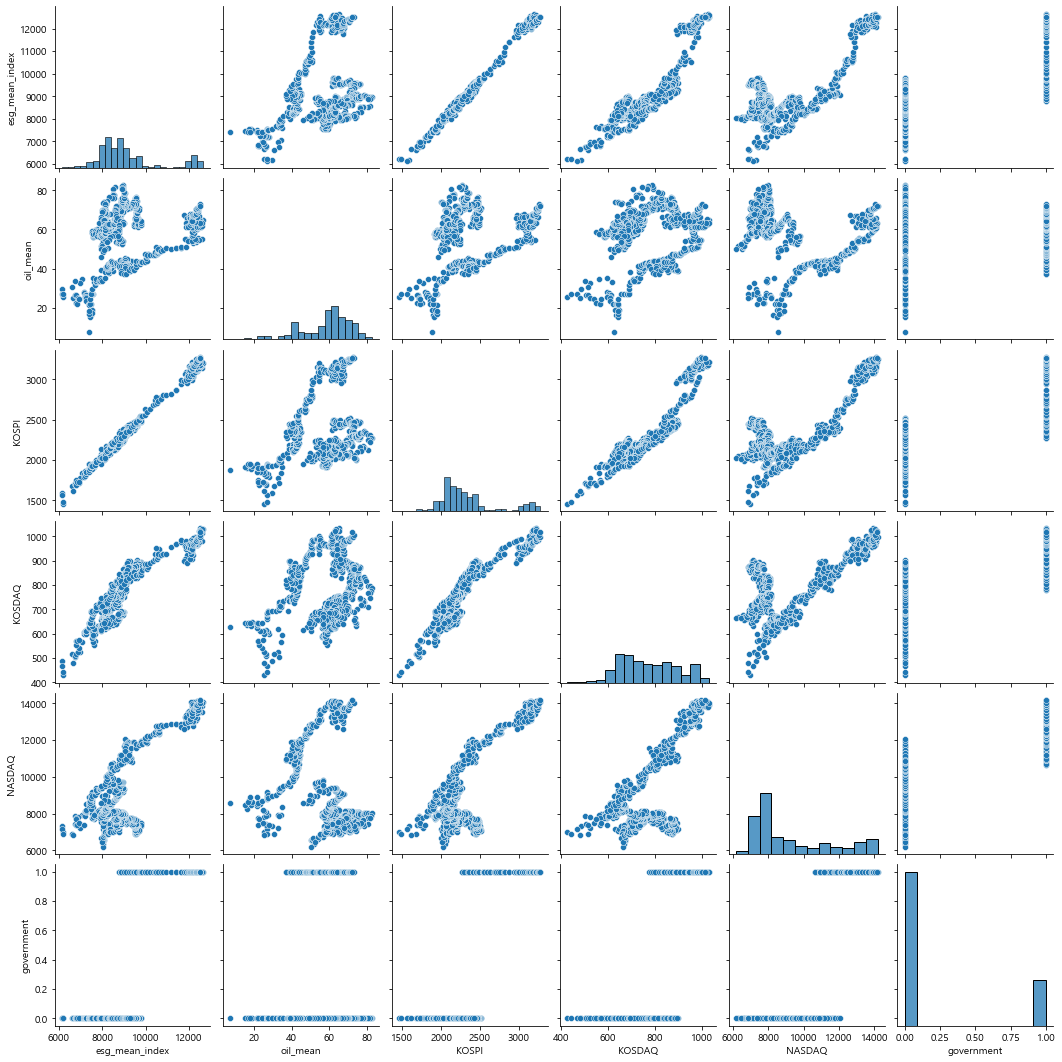

In [32]:
#각 변수들간의 관계를 한 눈에 파악 할 수 있다.
plt.rcParams["figure.figsize"] = (10,10)
sns.pairplot(whole_set, diag_kind = 'hist')
plt.show

## 꺾은선 그래프 그리기

Text(0, 0.5, 'INDEX')

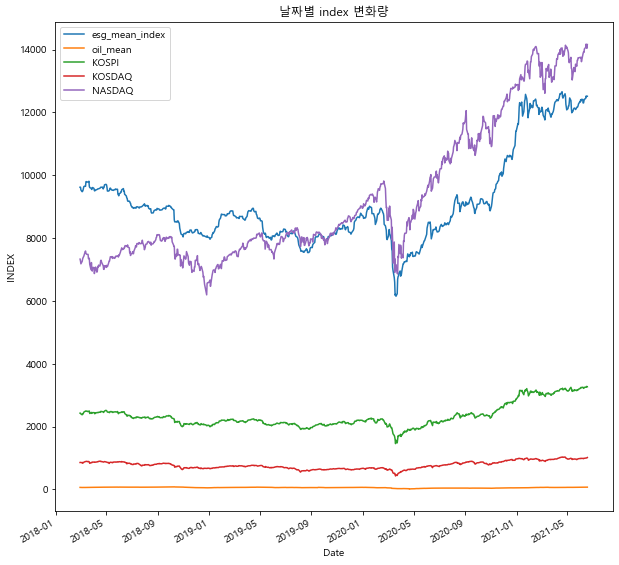

In [33]:
whole_set.plot(kind = 'line', x = 'Date', y = ['esg_mean_index', 'oil_mean', 'KOSPI','KOSDAQ','NASDAQ'])

plt.title("날짜별 index 변화량")
plt.xlabel("Date")
plt.ylabel("INDEX")
#꺾은선 그래프를 통해 한 눈에 각 변수들의 변화치를 한눈에 파악할 수 있을 것이다.


Text(0, 0.5, 'INDEX')

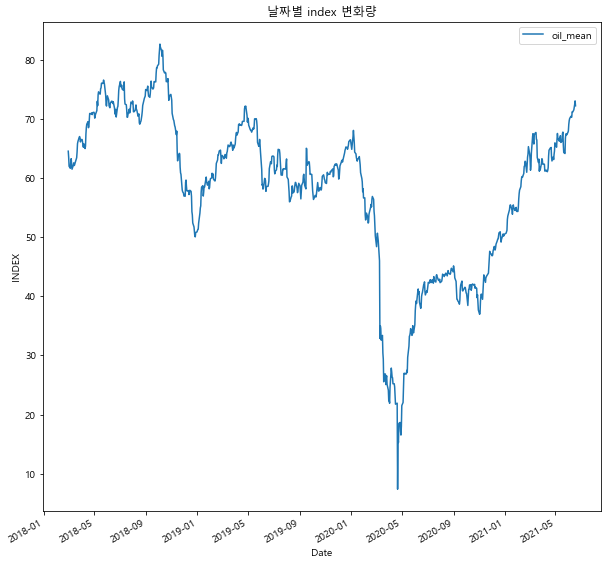

In [34]:
#폭의 차이가 커서 잘 확인이 되지 않는 국제 유가 데이터만 따로 빼서 확인해보기.
whole_set.plot(kind = 'line', x = 'Date', y =  'oil_mean')

plt.title("날짜별 index 변화량")
plt.xlabel("Date")
plt.ylabel("INDEX")

# 전체 관측치의 회귀분석

In [35]:
model1 = smf.ols(formula='esg_mean_index ~  oil_mean + KOSPI + KOSDAQ + NASDAQ + government', data=whole_set) 
results1 = model1.fit()

#print(results. summary()) 
Table1 = pd. DataFrame({'b': round(results1.params, 4), 
                       'se': round(results1.bse, 4),
                       't': round(results1.tvalues, 4), 
                       'pval': round(results1.pvalues, 4)}) 
print(f'Table1: \n{Table1}\n')
print (f'R2: {round(results1.rsquared, 4) }\n') 

Table1: 
                   b       se        t    pval
Intercept   282.1941  46.0685   6.1255  0.0000
oil_mean     -0.2429   0.5236  -0.4639  0.6428
KOSPI         4.2640   0.0510  83.6676  0.0000
KOSDAQ       -1.0810   0.0958 -11.2806  0.0000
NASDAQ       -0.0277   0.0055  -5.0276  0.0000
government   24.8389  22.4528   1.1063  0.2689

R2: 0.9929



결정계수가 정말 높은 값으로 나온 것을 확인할 수 있다. oil_mean, government변수가 p값에 근거해 의미 없는 변수로 나온 것을 확인할 수 있다.

# oil_mean 변수 제외 회귀분석

In [36]:
model2 = smf.ols(formula='esg_mean_index ~  KOSPI + KOSDAQ + NASDAQ + government', data=whole_set) 
results2 = model2.fit()

#print(results. summary()) 
Table2 = pd. DataFrame({'b': round(results2.params, 4), 
                       'se': round(results2.bse, 4),
                       't': round(results2.tvalues, 4), 
                       'pval': round(results2.pvalues, 4)}) 
print(f'Table1: \n{Table2}\n')
print (f'R2: {round(results2.rsquared, 4) }\n') 

Table1: 
                   b       se         t    pval
Intercept   280.0609  45.8173    6.1126  0.0000
KOSPI         4.2476   0.0367  115.8610  0.0000
KOSDAQ       -1.0675   0.0913  -11.6974  0.0000
NASDAQ       -0.0261   0.0042   -6.2097  0.0000
government   26.9981  21.9549    1.2297  0.2191

R2: 0.9929



# government 변수 제외 회귀분석

In [37]:
model3 = smf.ols(formula='esg_mean_index ~ oil_mean + KOSPI + KOSDAQ + NASDAQ', data=whole_set) 
results3 = model3.fit()

#print(results. summary()) 
Table3 = pd. DataFrame({'b': round(results3.params, 4), 
                       'se': round(results3.bse, 4),
                       't': round(results3.tvalues, 4), 
                       'pval': round(results3.pvalues, 4)}) 
print(f'Table1: \n{Table3}\n')
print (f'R2: {round(results3.rsquared, 4) }\n') 

Table1: 
                  b       se        t    pval
Intercept  243.7274  30.2240   8.0640  0.0000
oil_mean    -0.3630   0.5123  -0.7085  0.4788
KOSPI        4.2801   0.0488  87.6356  0.0000
KOSDAQ      -1.0882   0.0956 -11.3801  0.0000
NASDAQ      -0.0257   0.0052  -4.9432  0.0000

R2: 0.9928



# oil_mean, government 변수 동시 제외 회귀분석

In [38]:
model4 = smf.ols(formula='esg_mean_index ~ KOSPI + KOSDAQ + NASDAQ', data=whole_set) 
results4 = model4.fit()

#print(results. summary()) 
Table4 = pd. DataFrame({'b': round(results4.params, 4), 
                       'se': round(results4.bse, 4),
                       't': round(results4.tvalues, 4), 
                       'pval': round(results4.pvalues, 4)}) 
print(f'Table1: \n{Table4}\n')
print (f'R2: {round(results4.rsquared, 4) }\n') 

Table1: 
                  b       se         t  pval
Intercept  235.1752  27.7012    8.4897   0.0
KOSPI        4.2567   0.0359  118.5151   0.0
KOSDAQ      -1.0681   0.0913  -11.7003   0.0
NASDAQ      -0.0228   0.0033   -7.0096   0.0

R2: 0.9928



#### 회귀식에 대한 유의성을 F검정으로 확인해본다.

In [39]:
#H0 : oil_mean = KOSPI = KOSDAQ = NASDAQ = government =  0
#H1 : oil_mean != 0 or KOSPI != 0 or KOSDAQ != 0 or NASDAQ != 0 or government != 0
hypotheses = ['oil_mean  = 0', 'KOSPI = 0', 'KOSDAQ = 0','NASDAQ = 0', 'government = 0']
F_results = results1.f_test(hypotheses)
F_val = float(F_results.statistic)
p_val = float(F_results.pvalue)
print('F-value :', round(F_val,4))
print('P-value :', round(p_val,4))


F-value : 23646.8036
P-value : 0.0


# 잔차 그래프

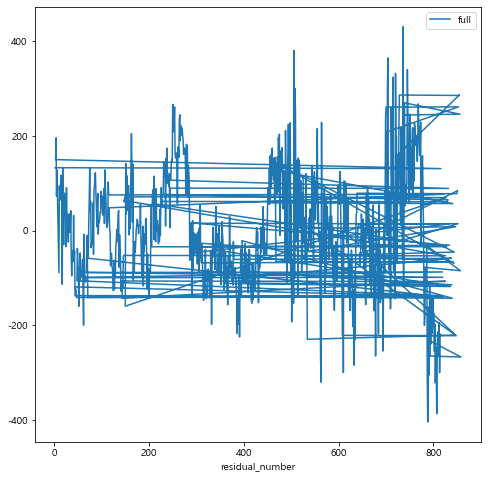

In [40]:
plt.rcParams["figure.figsize"] = (8,8)
results1.resid.plot(label = 'full')
plt.xlabel("residual_number")
plt.plot()
plt.legend()
plt.show()

# 모형의 선형성 판단

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


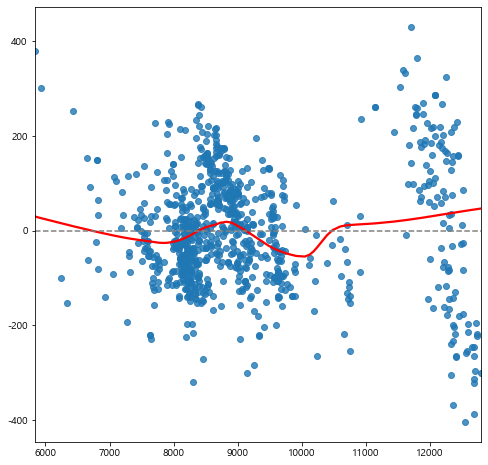

In [41]:
fitted = results1.predict(whole_set)
residual = whole_set['esg_mean_index'] - fitted
sns.regplot(fitted, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([fitted.min(), fitted.max()], [0, 0], '--', color='grey')

# 독립성 검정

In [42]:
from statsmodels.stats.stattools import durbin_watson

durbinWatson = durbin_watson(results1.resid)

print('Durbin-Watson:', durbinWatson)
if durbinWatson < 1.5:
    print('Signs of positive autocorrelation', '\n')
    print('Assumption not satisfied')
elif durbinWatson > 2.5:
    print('Signs of negative autocorrelation', '\n')
    print('Assumption not satisfied')
else:
    print('Little to no autocorrelation', '\n')
    print('Assumption satisfied')

Durbin-Watson: 0.7017714499379151
Signs of positive autocorrelation 

Assumption not satisfied


# 정규성 검정

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


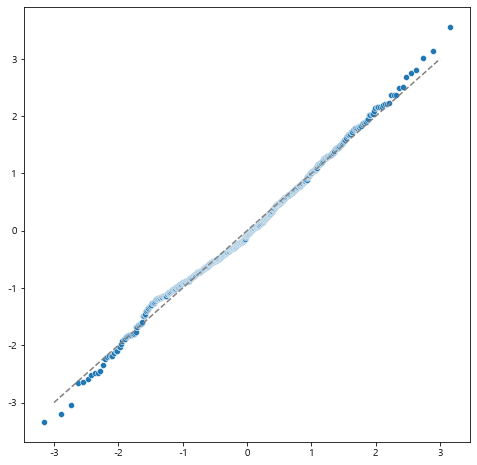

In [43]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)

sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

# 등분산성 검정

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

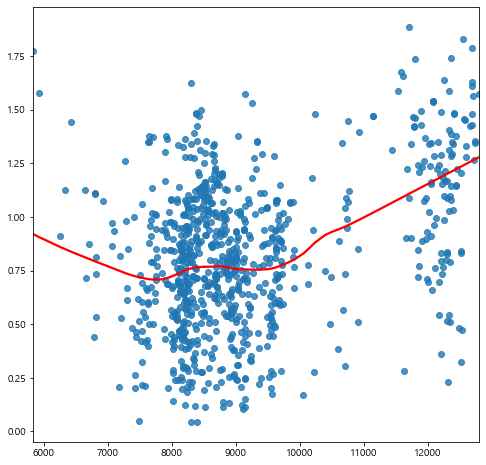

In [44]:
sns.regplot(fitted, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})

# 극단값 찾기

In [45]:
from statsmodels.stats.outliers_influence import OLSInfluence

cd, _ = OLSInfluence(results1).cooks_distance
cd.sort_values(ascending=False).head()

506    0.031556
788    0.018447
508    0.018378
807    0.017999
633    0.016309
dtype: float64

# 상관행렬

In [46]:
#KOSPI와 종속변수의 상관계수가 매우 높은 것을 확인할 수 있다.
#KOSPI의 다른 열과의 상관계수가 상대적으로 높은 것으로 봐 다중공산성이 존재하지 않을까 의심된다.
whole_set.corr()

,esg_mean_index,oil_mean,KOSPI,KOSDAQ,NASDAQ,government
esg_mean_index,1.000000,0.286063,0.995745,0.906605,0.798995,0.804157
oil_mean,0.286063,1.000000,0.272294,0.239087,-0.204955,-0.107337
KOSPI,0.995745,0.272294,1.000000,0.922251,0.810361,0.811002
KOSDAQ,0.906605,0.239087,0.922251,1.000000,0.699953,0.716731
NASDAQ,0.798995,-0.204955,0.810361,0.699953,1.000000,0.877028
government,0.804157,-0.107337,0.811002,0.716731,0.877028,1.000000


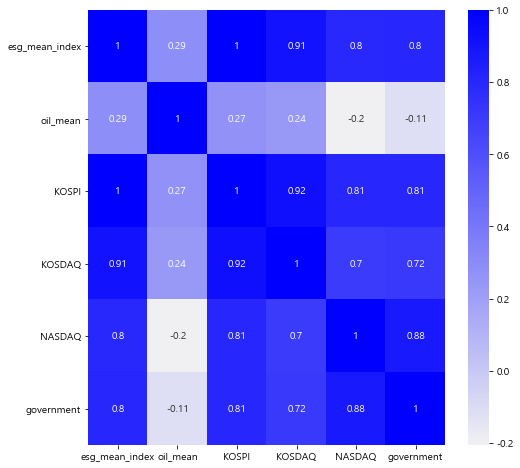

In [47]:
#위의 행렬을 보여주기 쉽게 변경
#잔차분석 및 특이값 확인
cmap = sns.light_palette("blue", as_cmap=True)
sns.heatmap(whole_set.corr(), annot=True, cmap=cmap)
plt.show()


# 다중공산성 검정

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.DataFrame({'컬럼':column,'VIF':variance_inflation_factor(model1.exog,i)}
            for i, column in enumerate(model1.exog_names)
            if column !='Intercept')

,컬럼,VIF
0,oil_mean,2.877400
1,KOSPI,20.924946
2,KOSDAQ,7.708845
3,NASDAQ,8.750636
4,government,5.185143
